# Analyze the Sample Rate of the Signals

In [1]:
import os
import sys
import math
sys.path.append(os.path.join(os.getcwd().partition('Code')[0], "Code"))
from src.config_base import GeneralConfig

In [2]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator, FixedLocator
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

In [3]:
from src.data.read_pickle import ReadPickle
from src.filtering.filter_methods import FilterMethods
from src.voltage_capacity_analysis.ica import ICA
from src.voltage_capacity_analysis.dva import DVA
from src.visualization.config_visualization import VisualizationConfig, instantiate_matplotlib_parameters, cm2inch
instantiate_matplotlib_parameters()
from src.visualization.colormaps import ColorMaps
from src.utils.bode_utils import Bode
from bode_utils import set_log_ticks

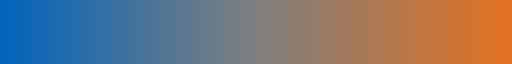

In [4]:
tum_cmap = ColorMaps.blue_orange_tum(grayscale=0.5)
colors = tum_cmap(np.linspace(0,1, 7))
ind_colors = [0,1,2,-1,-2,-3]
tum_cmap

## Read VW Cell File

In [5]:
path2files = os.path.join(GeneralConfig.path2data.value,"Tesla","vehicle")

In [6]:
def filter_func_preprocess_U(signal):
    perc_filter = 2/100 * len(signal) #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [7]:
def filter_func_preprocess_Q(signal):
    perc_filter = 2/100 * len(signal) #% filter
    filtered_signal = FilterMethods().rolling_mean_df(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter))
    #filtered_signal = FilterMethods().savgol(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return filtered_signal

In [8]:
read_pickle = ReadPickle()
read_pickle.set_filter_U(filter_func_preprocess_U)
read_pickle.set_filter_Q(filter_func_preprocess_Q)

In [9]:
vehicle = "Tesla_JB_8A_CEE7_C57_2021.pkl"

In [10]:
df_1 =  read_pickle.read(os.path.join(path2files,vehicle)) # alle 10s

In [11]:
df_1.time_s.diff().mean()

10.0

In [12]:
df_2 =  read_pickle.read(os.path.join(path2files,vehicle),resample=60) 

In [13]:
df_2.time_s.diff().mean()

60.0

In [14]:
df_3 =  read_pickle.read(os.path.join(path2files,vehicle),resample=5*60) 

In [15]:
df_3.time_s.diff().mean()

300.0

In [16]:
df_4 =  read_pickle.read(os.path.join(path2files,vehicle),resample=15*60) 

In [17]:
df_4.time_s.diff().mean()

900.0

In [18]:
df_5 =  read_pickle.read(os.path.join(path2files,vehicle),resample=30*60) 

In [19]:
df_5.time_s.diff().mean()

1800.0

In [20]:
df_6 =  read_pickle.read(os.path.join(path2files,vehicle),resample=60*60)

In [21]:
df_6.time_s.diff().mean()

3600.0

In [22]:
def no_filt(signal):
    return signal

In [23]:
def filter_func_1(signal):
    perc_filter =1 #% filter
    filtered_signal = FilterMethods().rolling_mean_numpy(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    filtered_signal_reverse = FilterMethods().rolling_mean_numpy(np.flip(signal),window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return (filtered_signal+np.flip(filtered_signal_reverse))/2

In [24]:
def filter_func_4(signal):
    ws = FilterMethods().round_to_next_odd_number(1/100 * len(signal))+1 # to mitigate the sinus 
    filtered_signal = FilterMethods().rolling_mean_numpy(signal,window_size=ws)
    filtered_signal_reverse = FilterMethods().rolling_mean_numpy(np.flip(signal),window_size=ws)
    return (filtered_signal+np.flip(filtered_signal_reverse))/2

In [25]:
def filter_func_6(signal):
    perc_filter = 10 #% filter
    filtered_signal = FilterMethods().rolling_mean_numpy(signal,window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    filtered_signal_reverse = FilterMethods().rolling_mean_numpy(np.flip(signal),window_size=FilterMethods().round_to_next_odd_number(perc_filter/100 * len(signal)))
    return (filtered_signal+np.flip(filtered_signal_reverse))/2

In [26]:
dva_extractor = DVA()
dva_extractor.set_filter(filter_func_1)
dva_1, cap_1 =dva_extractor.get_dva(time=df_1["time_h"], capacity=df_1["Q"], voltage=df_1["U"],crop_cap_Ah=(1,161))

dva_extractor.set_filter(filter_func_1)
dva_2, cap_2 =dva_extractor.get_dva(time=df_2["time_h"], capacity=df_2["Q"], voltage=df_2["U"],crop_cap_Ah=(1,161))

dva_extractor.set_filter(filter_func_1)
dva_3, cap_3 =dva_extractor.get_dva(time=df_3["time_h"], capacity=df_3["Q"], voltage=df_3["U"],crop_cap_Ah=(1,161))

dva_extractor.set_filter(filter_func_4)
dva_4, cap_4 =dva_extractor.get_dva(time=df_4["time_h"], capacity=df_4["Q"], voltage=df_4["U"],crop_cap_Ah=(1,161))

dva_extractor.set_filter(filter_func_1)
dva_5, cap_5 =dva_extractor.get_dva(time=df_5["time_h"], capacity=df_5["Q"], voltage=df_5["U"],crop_cap_Ah=(1,161))

dva_extractor.set_filter(filter_func_1)
dva_6, cap_6 =dva_extractor.get_dva(time=df_6["time_h"], capacity=df_6["Q"], voltage=df_6["U"],crop_cap_Ah=(1,161))

In [27]:
ica_extractor = ICA()
ica_extractor.set_filter(filter_func_1)
ica_extractor.set_post_filter(filter_func_1)
ica_1, volt_1 = ica_extractor.get_ica(time=df_1["time_h"], capacity=df_1["Q"], voltage=df_1["U"],crop_volt_V=(0,390),postfilter=False,postfilter_volt_range=(3.315,3.34),IQR_filter=True,absolute=True)
ica_2, volt_2 = ica_extractor.get_ica(time=df_2["time_h"], capacity=df_2["Q"], voltage=df_2["U"],crop_volt_V=(0,390),postfilter=False,postfilter_volt_range=(3.315,3.34),IQR_filter=True,absolute=True)
ica_3, volt_3 = ica_extractor.get_ica(time=df_3["time_h"], capacity=df_3["Q"], voltage=df_3["U"],crop_volt_V=(0,390),postfilter=False,postfilter_volt_range=(3.315,3.34),IQR_filter=True,absolute=True)

ica_5, volt_5 = ica_extractor.get_ica(time=df_5["time_h"], capacity=df_5["Q"], voltage=df_5["U"],crop_volt_V=(0,390),postfilter=False,postfilter_volt_range=(3.315,3.34),IQR_filter=True,absolute=True)
ica_6, volt_6 = ica_extractor.get_ica(time=df_6["time_h"], capacity=df_6["Q"], voltage=df_6["U"],crop_volt_V=(0,390),postfilter=False,postfilter_volt_range=(3.315,3.34),IQR_filter=True,absolute=True)

ica_extractor.set_filter(filter_func_1)
ica_4, volt_4 = ica_extractor.get_ica(time=df_4["time_h"], capacity=df_4["Q"], voltage=df_4["U"],crop_volt_V=(0,390),postfilter=False,postfilter_volt_range=(3.315,3.34),IQR_filter=True,absolute=True)


## fokus on the graphite peak, as this peak shows the greatest change in voltage in teh area of interest. if this peak cannot be resolved, the sample rate is to low 

### Plots

In [28]:
def DVA_plot_v(axes, lst_cap, lst_dva):
    Q_nom = 161
    # 6 Ah shift compared to cell
    alpha=1
    for ind,(cap,dva) in enumerate(zip(lst_cap,lst_dva)):
        axes.plot(cap,dva*Q_nom,color=colors[ind_colors[ind]],alpha=alpha)
        alpha-=0
    axes.set_ylabel(r"$Q_{veh.}\cdot\frac{dU_{veh.}}{dQ_{veh.}}$ in V",fontsize=9)
    axes.set_xlabel(r"Vehicle charge in Ah",fontsize=9) 
    
    axes.set_xlim([0,166])
    axes.set_ylim([0,106])
    tick_positions =np.array([0,27,54,81,106])
    axes.set_yticks(tick_positions)
    tick_positions = np.array([0,40,80,120,161])
    axes.set_xticks(tick_positions)
    axes.xaxis.set_minor_locator(FixedLocator([20,60,100,140]))
    axes.grid(color="gainsboro")
    axes.set_axisbelow(True)
    
    # inset axes left
    axins = axes.inset_axes([110, 10, 36,90],transform = axes.transData) # [x0, y0, width, height]
    alpha=1
    for ind,(cap,dva) in enumerate(zip(lst_cap,lst_dva)):
        axins.plot(cap,dva*Q_nom,color=colors[ind_colors[ind]],alpha=alpha)
        alpha-=0
    # subregion of the original image
    x1, x2, y1, y2 = 90, 98,30,53
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    axins.set_xticks([])
    axins.set_yticks([])
    #axins.grid()
    axes.indicate_inset_zoom(axins, edgecolor="black")
    return axes

In [29]:
def ICA_plot_v1(axes, lst_volt, lst_ica):
    alpha=1
    for ind,(volt,ica) in enumerate(zip(lst_volt,lst_ica)):
        axes.plot(volt,ica,color=colors[ind_colors[ind]],alpha=alpha)
    
    axes.set_ylabel(r"$\frac{dQ_{veh.}}{dU_{veh.}}$ in $\frac{Ah}{V}$",fontsize=9)
    axes.set_xlabel(r"Vehicle voltage in V",fontsize=9) 
    axes.set_xlim([350,360])
    axes.set_ylim([0,200])
    tick_positions =np.array([0,50,100,150,200])
    axes.set_yticks(tick_positions)
    tick_positions = np.array(list(range(350,361,5)))#np.array([330,356,382])
    axes.set_xticks(tick_positions)
    axes.grid(axis='both')
    #axes.xaxis.set_minor_locator(FixedLocator([20,60,100,140]))
    axes.set_axisbelow(True)
    axes.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    axes.tick_params('y', left=True, labelleft=True,right=True, labelright=False)
    axes.tick_params(axis='x', labelsize=9)
    axes.tick_params(axis='y', labelsize=9)
    
    return axes

In [30]:
def ICA_plot_v2(axes, lst_volt, lst_ica):
    alpha=1
    for ind,(volt,ica) in enumerate(zip(lst_volt,lst_ica)):
        axes.plot(volt,ica,color=colors[ind_colors[-3]],alpha=alpha)
    
    #axes.set_ylabel(r"$\frac{dQ_{veh.}}{dU_{veh.}}$ in $\frac{Ah}{V}$",fontsize=9)
    axes.set_xlabel(r"Vehicle voltage in V",fontsize=9) 
    axes.set_xlim([350,360])
    #axes.set_ylim([0,200])
    #tick_positions =np.array([0,50,100,150,200])
    #axes.set_yticks(tick_positions)
    tick_positions = np.array(list(range(350,361,5)))#np.array([330,356,382])
    axes.set_xticks(tick_positions)
    axes.grid(axis='both')
    #axes.xaxis.set_minor_locator(FixedLocator([20,60,100,140]))
    axes.set_axisbelow(True)
    axes.tick_params('x', top=False, labeltop=False,bottom=True, labelbottom=True)
    axes.tick_params('y', left=True, labelleft=False,right=True, labelright=False)
    axes.tick_params(axis='x', labelsize=9)
    axes.tick_params(axis='y', labelsize=9)
    
    return axes

C:\Users\ga97req\AppData\Local\Temp\ipykernel_12144\2023743721.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\ga97req\AppData\Local\Temp\ipykernel_12144\2023743721.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


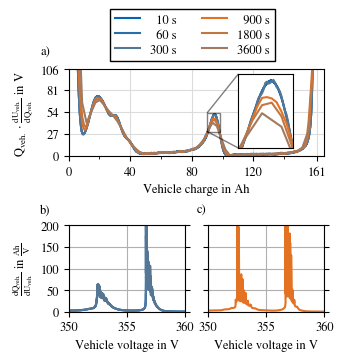

In [31]:
nrow = 2
fig= plt.figure(figsize=(VisualizationConfig.columnwidth_in_in.value,
                                nrow*cm2inch(4)),layout="constrained")
gs = gridspec.GridSpec(2, 2,hspace=0.8)

axes_DVA = fig.add_subplot(gs[0, :])
axes_DVA = DVA_plot_v(axes_DVA, [cap_1,cap_2,cap_3,cap_4,cap_5,cap_6], lst_dva = [dva_1,dva_2,dva_3,dva_4,dva_5,dva_6])

axes_ICA = fig.add_subplot(gs[1, 0])
axes_ICA = ICA_plot_v1(axes_ICA, lst_volt = [volt_1,volt_2,volt_3], lst_ica = [ica_1,ica_2,ica_3])


axes_ICA2 = fig.add_subplot(gs[1, 1],sharey=axes_ICA)
axes_ICA2 = ICA_plot_v2(axes_ICA2, lst_volt = [volt_4], lst_ica=[ica_4])

handles, labels = axes_DVA.get_legend_handles_labels() 
line1 = Line2D([0], [0], label='  10 s', color=colors[ind_colors[0]])
line2 = Line2D([0], [0], label='  60 s', color=colors[ind_colors[1]])
line3 = Line2D([0], [0], label='300 s', color=colors[ind_colors[2]])
line4 = Line2D([0], [0], label='  900 s', color=colors[ind_colors[3]])
line5 = Line2D([0], [0], label='1800 s', color=colors[ind_colors[4]])
line6 = Line2D([0], [0], label='3600 s', color=colors[ind_colors[5]])
# add manual symbols to auto legend
handles.extend([line1, line2, line3, line4, line5, line6])
lgd = fig.legend(handles=handles,loc="center",fontsize=9,framealpha =1 ,ncol=2, fancybox=False,labelspacing=0.25,edgecolor="black",bbox_to_anchor=(0.5, 0.99))


plt.tight_layout()
axes_DVA.text(-0.11, 1.2, 'a)', horizontalalignment='left',fontsize=9,
     verticalalignment='center', transform=axes_DVA.transAxes)
axes_ICA.text(-0.25, 1.18, r'b)', horizontalalignment='left',fontsize=9,
     verticalalignment='center', transform=axes_ICA.transAxes)
axes_ICA2.text(-0.1, 1.18, r'c)', horizontalalignment='left',fontsize=9,
     verticalalignment='center', transform=axes_ICA2.transAxes)

fig.savefig(os.path.join(GeneralConfig.path2figures.value,"03-DVA_ICA_Sample_Rate_Tesla.pdf"),bbox_extra_artists=([lgd]),bbox_inches="tight")
fig.savefig(os.path.join(GeneralConfig.path2figures.value,"03-DVA_ICA_Sample_Rate_Tesla.png"),dpi=300,bbox_inches="tight")

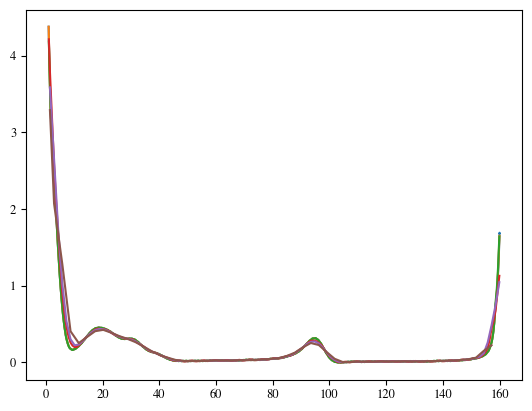

In [32]:
plt.plot(cap_1,dva_1)
plt.plot(cap_2,dva_2)
plt.plot(cap_3,dva_3)
plt.plot(cap_4,dva_4)
plt.plot(cap_5,dva_5)
plt.plot(cap_6,dva_6)

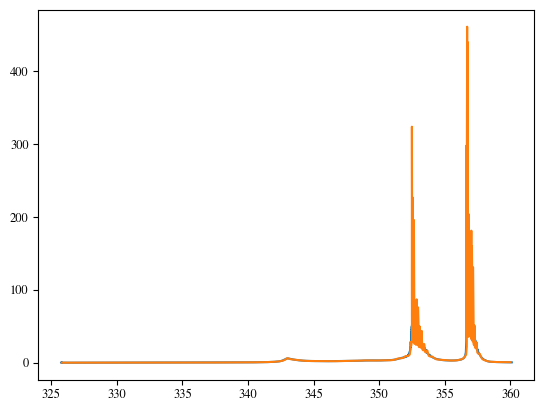

In [33]:
plt.plot(volt_1,ica_1)
#plt.plot(volt_2,ica_2)
#plt.plot(volt_3,ica_3)
plt.plot(volt_4,ica_4)
#plt.plot(volt_5,ica_5)
#plt.plot(volt_6,ica_6)
